# Tarea 2: Reconocimiento intermedio - Clasificador de lunares cancerígenos.
Reconocimiento de Patrones (IIC2233)

Primer semestre 2024

Pedro Pablo Zavala Tejos

# 0. Initial Setup

💬 Instalamos las librerias Balu3 y Pyxvis ...

In [2]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 1.45 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=63a64175c7e8aec472c2794b6a2e0874172936a847bd49090715cc363ed10322
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhd__lmu/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [132]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2

# Balu
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm
from   balu3.im.proc import im_grad,fspecial,gradlog
from   balu3.ft.trans  import pca

# Seaborn
from   seaborn import heatmap

# Sklearn
from   sklearn.metrics   import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from   sklearn.neighbors import KNeighborsClassifier


print('* Librerias cargadas *')

* Librerias cargadas *


# 1. Image Loading


In [4]:
!wget https://www.dropbox.com/scl/fi/f9qbp1mqdd7mdyck9geur/skin5Fix.zip?rlkey=fcsw2pbeybp9y85nv9f7fgpnj&e=1&st=iufuvqoi&dl=0

--2024-05-10 01:25:43--  https://www.dropbox.com/scl/fi/f9qbp1mqdd7mdyck9geur/skin5Fix.zip?rlkey=fcsw2pbeybp9y85nv9f7fgpnj
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9cf28e2ebe522876c04923b782.dl.dropboxusercontent.com/cd/0/inline/CSmGl1Nc6QUWwav_GzKNB7QOx6vjdxnbmU7KEz09qU32iEfxZ0UCpbKzN2PM0bIQmkIAZUehtW-zYeXUjyY0WHdk4jCtMGGTZuMCDyhXicj4_nQne5jbBp8_BlUCWJbOIG-prIw2FSrcElA2rZyM_L91/file# [following]
--2024-05-10 01:25:44--  https://uc9cf28e2ebe522876c04923b782.dl.dropboxusercontent.com/cd/0/inline/CSmGl1Nc6QUWwav_GzKNB7QOx6vjdxnbmU7KEz09qU32iEfxZ0UCpbKzN2PM0bIQmkIAZUehtW-zYeXUjyY0WHdk4jCtMGGTZuMCDyhXicj4_nQne5jbBp8_BlUCWJbOIG-prIw2FSrcElA2rZyM_L91/file
Resolving uc9cf28e2ebe522876c04923b782.dl.dropboxusercontent.com (uc9cf28e2ebe522876c04923b782.dl.dropboxusercontent.com)... 162.125.13.15, 2620:

💬 Cargamos los datos desde dropbox



In [5]:
!mv skin5Fix.zip?rlkey=fcsw2pbeybp9y85nv9f7fgpnj skin5Fix.zip

In [6]:
!unzip -qq skin5Fix.zip
print('* Bases de datos cargada correctamente *')

* Bases de datos cargada correctamente *


---
💬 Definimos las siguientes funciones para cargar una imagen.


**Referencia**: estas funciones las utilice en mi tarea 1. Algunas fueron sacadas directamente de las primeras actividades, mientras que otras las cree yo.

In [7]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """
    DIGITS_CLASS = 2
    DIGITS_IMG = 4
    CLASS_PREFIX = {
        '01' : 'bcc',
        '02' : 'bkl',
        '03' : 'akiec',
        '04' : 'mel',
        '05' : 'nv',
    }
    FPATH = 'skin5Fix'

    img_class = num2fixstr(num_class, 2)
    img_num = num2fixstr(num_img, 4)

    img_class_name = CLASS_PREFIX[img_class]

    BASE_URL = f'{FPATH}/{img_class}_{img_class_name}'
    IMG_NAME = f'skin_{img_class}_{img_num}.png'


    path = f'{BASE_URL}/{IMG_NAME}'

    return path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


💬 Cargamos una imagen de ejemplo de 256x256 pixeles para la clase 1 (lunares tipo BCC)

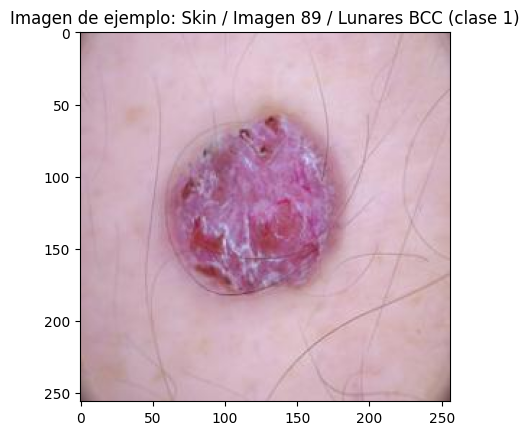

In [8]:
test_img = imageload(1,89)
plt.imshow(test_img, cmap='gray')
plt.title('Imagen de ejemplo: Skin / Imagen 89 / Lunares BCC (clase 1)')
plt.show()

### Preprocesamiento de imagenes

💬 Primero, preprocesaremos las imagenes para eliminar cierta informacion que deberiamos no extraer. Por ejemplo, los pelos, o manchas de la piel. Para asi, poder tener una mejor clasificacion enfocandonos solamente en la region del lunar.Para esto realizaremos el siguiente proceso:
... [COMPLETAR]


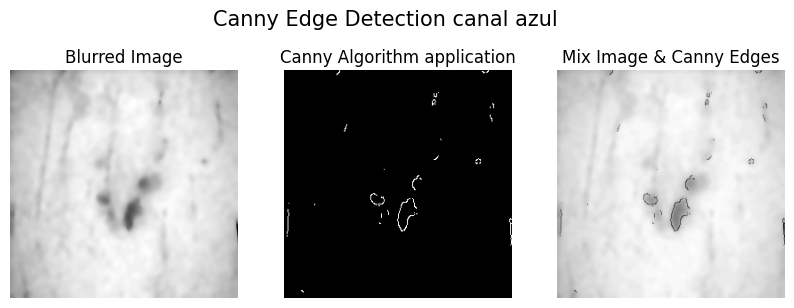

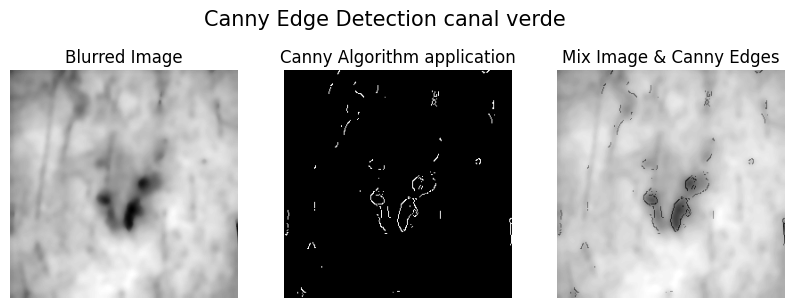

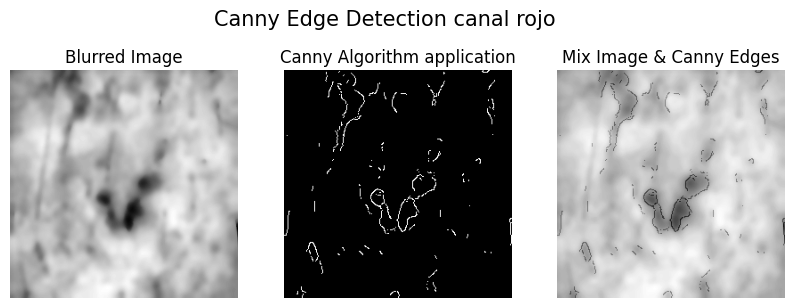

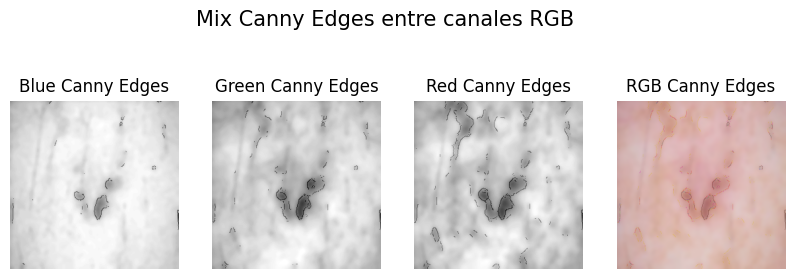

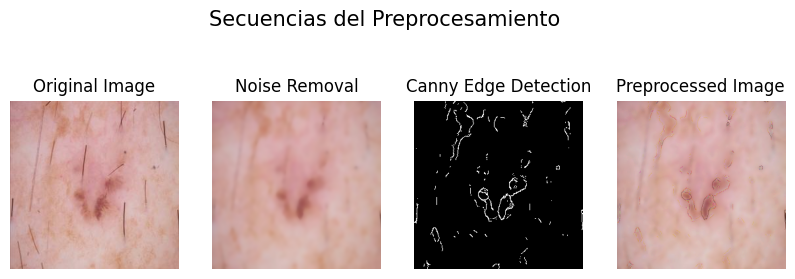

In [9]:
def blurring(img, blur_type):
    if blur_type == 'gaussian': # Gaussian blurring
        return cv2.GaussianBlur(img, (5,5), 0)
    elif blur_type == 'median': # Median blurring
        return cv2.medianBlur(img, 5)
    elif blur_type == 'bilateral': # Bilateral Filtering
        return cv2.bilateralFilter(img, 9, 75, 75)

def blur_image(img):
    img1 = blurring(img, 'median')
    img2 = blurring(img1, 'bilateral')
    return img2


def canny_edge(img, channel, show):
    # La imagen ya viene con el ruido sacado.

    # -- Canny Edge Detection Operation --
    canny_img = cv2.Canny(img, 35, 35)
    inv_canny_img = np.bitwise_not(canny_img) # Inverted canny edge img

    # -- Mix Canny and blurred img --
    alpha = 0.15
    beta = 1.0 - alpha
    mix = cv2.addWeighted(inv_canny_img, alpha, img.astype(inv_canny_img.dtype), beta, 0.0)

    if show:
        fig, ax = plt.subplots(1, 3, figsize=(10, 10))
        fig.suptitle(f'Canny Edge Detection canal {channel}', fontsize=15)

        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Blurred Image')

        ax[1].imshow(canny_img, cmap='gray')
        ax[1].set_title('Canny Algorithm application')

        ax[2].imshow(mix, cmap='gray')
        ax[2].set_title('Mix Image & Canny Edges')

        for axs in ax:
            axs.axis('off')

        plt.subplots_adjust(top=1.5)
        plt.show()
        print()

    return mix, canny_img

def mole_edge(img, show):
    blue_channel, green_channel, red_channel = cv2.split(img)
    b_mix, b_canny = canny_edge(blue_channel, 'azul', show) # Aplicacion del algoritmo Canny para el canal azul
    g_mix, g_canny = canny_edge(green_channel, 'verde', show) # Aplicacion del algoritmo Canny para el canal verde
    r_mix, r_canny = canny_edge(red_channel, 'rojo', show) #Aplicacion del algoritmo Canny para el canal rojo

    rgb_mix = cv2.merge([b_mix, g_mix, r_mix])
    rgb_canny = (r_canny + g_canny + b_canny)


    if show:
        fig, ax = plt.subplots(1, 4, figsize=(10, 10))
        fig.suptitle('Mix Canny Edges entre canales RGB', fontsize=15)
        ax[0].imshow(b_mix, cmap='gray')
        ax[0].set_title('Blue Canny Edges')

        ax[1].imshow(g_mix, cmap='gray')
        ax[1].set_title('Green Canny Edges')

        ax[2].imshow(r_mix, cmap='gray')
        ax[2].set_title('Red Canny Edges')

        ax[3].imshow(rgb_mix, cmap='gray')
        ax[3].set_title('RGB Canny Edges')

        for axs in ax:
            axs.axis('off')

        plt.subplots_adjust(top=1.5)
        plt.show()
        print()


    return rgb_mix, rgb_canny

def enhance_channel(channel):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(7,7))
    # Aplicamos Top-Hat opperation -> Enfasis en objetos claros en un fondo oscuro
    tophat_channel = cv2.morphologyEx(channel, cv2.MORPH_TOPHAT, kernel)
    # Aplicamos Black-Hat operation -> Enfasis en objetos oscuros en un fondo claro
    blackhat_channel = cv2.morphologyEx(channel, cv2.MORPH_BLACKHAT, kernel)
    # Operacion de mejora en el contraste de la imagen.
    enhance = channel + tophat_channel - blackhat_channel

    return enhance

def enhance(img):
    b, g, r = cv2.split(img)
    # Channel b/g/r Contrast Enhancement (CE)
    b_ce = enhance_channel(b)
    g_ce = enhance_channel(g)
    r_ce = enhance_channel(r)

    img_ce = cv2.merge([b_ce, g_ce, r_ce ])

    return img_ce


def preprocess(img, show=False):
    # Removemos el ruido de la imagen
    blurred_img = blur_image(img)
    # Obtenemos la mezcla de aplicaciones de los canales RGB utilizando Canny (rgb_mix)
    # y tambien la segmentacion misma (rgb_canny)
    rgb_mix, rgb_canny = mole_edge(blurred_img, show)
    # Aplicamos el resultado de la deteccion del borde del lunar sobre la imagen
    # sin ruido (blurred_img).
    alpha = 0.5 # Parametros que determinan el % de mezcla entre imagenes.
    beta = 1.0 - alpha
    # Imagen sin ruido y con un resaltado de la region donde se encuentra
    # el lunar.
    noise_remove_img = cv2.addWeighted(blurred_img, alpha, rgb_mix, beta, 0.0)
    # Realizamos una mejora en el contraste de la imagen usando operaciones
    # morfologicas.
    preprocessed_img = enhance(noise_remove_img)


    if show:
        fig, ax = plt.subplots(1, 4, figsize=(10, 10))
        fig.suptitle('Secuencias del Preprocesamiento', fontsize=15)
        ax[0].imshow(img)
        ax[0].set_title('Original Image')

        ax[1].imshow(blurred_img, cmap='gray')
        ax[1].set_title('Noise Removal')

        ax[2].imshow(rgb_canny, cmap='gray')
        ax[2].set_title('Canny Edge Detection')

        ax[3].imshow(preprocessed_img, cmap='gray')
        ax[3].set_title('Preprocessed Image')

        for axs in ax:
            axs.axis('off')

        plt.subplots_adjust(top=1.5)
        plt.show()
        print()

    # Retornamos la imagen preprocesada
    return preprocessed_img

# Imagen de testeo para preprocesamiento: Imagen 10 Clase 1.
test_img_preprocessing = imageload(1,10)
preprocessed_image = preprocess(test_img_preprocessing, show=True)



# 2. Feature Extraction

💬 Ahora extraeremos diferentes caracteristicas de la imagen. Para ello, primero preprocesaremos la imagen y luego extraeremos las caracteristicas de esta ultima.


In [10]:
K = 5 # Cantidad de clases del dataset
N = 240 # Cantidad de imagenes por clase
Y = np.zeros((K * N), 'int') # Vector de clasificacion


# ------------------------------- LBP ------------------------------------------
hdiv_0 = 8 # LBP con 1x1 particiones
vdiv_0 = 8
Mlbp = 10 * hdiv_0 * vdiv_0# Numero de elementos vector LBP
Xlbp = np.zeros((K * N, Mlbp))


# ----------------------------- HARALICK ---------------------------------------
Mhar = 24 # Numero de elmenentos vector Haralick para distancia = 3
Xhar = np.zeros((K * N, Mhar))
d_0 = 1 # Parametro de distancia

# ------------------------------- Hog ------------------------------------------
hog_orientations = 9
px_0 = 64 # Parametro pixeles por bloque
cl_0 = 2 # Parametro celdas por bloque
bn = 9 # Numero de bins del descriptor Hog.
Mhog = 324 # Numero de elementos en total del vector descriptor
Xhog = np.zeros((K * N, Mhog))


# ------------------------------- Gabor ----------------------------------------
rotations_0 = 8 # 8 rotaciones
dilations_0 = 8 # 8 escalas
Mgab = rotations_0 * dilations_0 + 3 # Numero de elementos vector de Gabor para 8 rotaciones y escalas
Xgab = np.zeros((K * N, Mgab))


In [11]:
def select_channel(img, selected_channel):
    blue_channel, green_channel, red_channel = cv2.split(img)
    if selected_channel == 'blue':
        return blue_channel
    elif selected_channel == 'green':
        return green_channel
    else: # selected_channel == 'red'
        return red_channel


def extract_features(selected_channel):
    t = 0
    # sc: Selected Channel (SC)
    # Inicializamos una matriz de caracteristicas para cada canal.
    Xlbp_sc = np.zeros((K * N, Mlbp))
    Xhar_sc = np.zeros((K * N, Mhar))
    Xhog_sc = np.zeros((K * N, Mhog))
    Xgab_sc = np.zeros((K * N, Mgab))

    print(f' Extracting features from {selected_channel} channel '.center(100, '*'))

    for k in range(K): # Por cada clase ...
        print(f'Extracting features: batch {k + 1}/5')

        for i in tqdm(range(N)): # Por cada imagen ...
            num_class = k + 1
            num_img = i + 1
            # Cargamos la i-esima imagen de la k-esima clase
            img = 255*imageload(num_class, num_img)
            # Preprocesamos la imagen para eliminar ruido y resaltar el lunar
            preprocessed_img = preprocess(img)
            # Extraemos la caracteristica del canal elegido (R, G o B).
            channel = select_channel(preprocessed_img, selected_channel)

            # LBP con 1x1 particiones
            Xlbp_sc[t,:] = lbp(channel, hdiv=hdiv_0, vdiv=vdiv_0,
                                mapping='uniform', norm=True)

            # Haralick con d=1 pixeles
            Xhar_sc[t,:] = haralick(channel, distance=d_0)

            # Hog con 9 orientaciones
            Xhog_sc[t,:] = hog(channel, orientations=hog_orientations,
                                cells_per_block=(cl_0, cl_0),
                                pixels_per_cell=(px_0, px_0),
                                norm=False)
            # Gabor
            Xgab_sc[t,:] = gabor(channel,
                                 dilations=dilations_0,
                                 rotations=rotations_0)

            # Vector de clasificacion
            Y[t] = k # Deberia ser el mismo para los 3 canales.
            t = t + 1

    return Xlbp_sc, Xhar_sc, Xhog_sc, Xgab_sc

💬 `EXTRACTION_FLAG`: Para poder cargar los datos desde la nube, su valor debe ser 0. En otro caso, si queremos extraer las caracteristicas de cada imagen su valor debe ser 1.

In [12]:
EXTRACTION_FLAG = 1

In [13]:
if EXTRACTION_FLAG:
    # Parametros para equilibrar la influencia de las caracteristicas a partir
    # de cada canal (peso). El valor esta en el intervalo [0,1].
    # blue channel
    alpha = 0.125 # 25%
    # green channel
    beta = 0.750 # 75%
    # red channel
    gamma = 0.125 # 25%

    # Extraemos las caracteristicas para cada canal y luego ponderamos por el
    # peso. Finalmente sumamos el resultado en la matriz de caracteristicas
    # segun el descriptor utilizado.

    for channel, weight in [('blue', alpha), ('green', beta), ('red', gamma)]:
        Xlbp_sc, Xhar_sc, Xhog_sc, Xgab_sc = extract_features(channel)

        Xlbp += (Xlbp_sc * weight)
        Xhar += (Xhar_sc * weight)
        Xhog += (Xhog_sc * weight)
        Xgab += (Xgab_sc * weight)

    # Guardamos las caracteristicas en la nube de archivos npy.
    np.save('lbp.npy', Xlbp)
    np.save('haralick.npy', Xhar)
    np.save('hog.npy', Xhog)
    np.save('gabor.npy', Xgab)

else:
    print('EXTRACTION_FLAG disabled: Extracting features from the cloud ...')
    Xlbp = np.load('lbp.npy')
    Xhar = np.load('haralick.npy')
    Xhog = np.load('hog.npy')
    Xgab = np.load('gabor.npy')

****************************** Extracting features from blue channel *******************************
Extracting features: batch 1/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 2/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 3/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 4/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 5/5


  0%|          | 0/240 [00:00<?, ?it/s]

****************************** Extracting features from green channel ******************************
Extracting features: batch 1/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 2/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 3/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 4/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 5/5


  0%|          | 0/240 [00:00<?, ?it/s]

******************************* Extracting features from red channel *******************************
Extracting features: batch 1/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 2/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 3/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 4/5


  0%|          | 0/240 [00:00<?, ?it/s]

Extracting features: batch 5/5


  0%|          | 0/240 [00:00<?, ?it/s]

In [14]:
X = np.concatenate((Xlbp, Xhar, Xhog, Xgab), axis=1)
print('Total de caracteristicas: ', X.shape[1])

Total de caracteristicas:  1055


# 3. Training and testing subsets

💬 Utilizaremos la funcion `SplitTrainTest` de las actividades E06 para separar los datos en training y testing.


In [15]:
# Separación entre training y testing
# las primeras n muestras de X serán para el training, el resto
# para el testing
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = int(X.shape[0]/K)        # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1

  return Xtrain,ytrain,Xtest,ytest

In [16]:
n_train = 200
Xtrain,Ytrain,Xtest,Ytest = SplitTrainTest(X, Y, n_train)


## Cleaning

In [17]:
sclean = clean(Xtrain)  # Indices de las caracteristicas seleccionadas con el
                        # algoritmo clean.
Xtrain_clean = Xtrain[:,sclean] # Nuevo training.
Xtest_clean = Xtest[:,sclean] # Nuevo testing.
print(f'Cantidad de caracteristicas seleccionadas: {sclean.shape[0]}')


Cantidad de caracteristicas seleccionadas: 1000


## Normalization

In [18]:
Xtrain_norm, a, b = minmax(Xtrain_clean)
Xtest_norm = Xtest_clean * a + b

# 4. Classification

In [72]:
p = 100
sfs_indices = sfs(Xtrain_norm, Ytrain, p)
print(sfs_indices)

[645 980 649 989 766 737 997 354 921 661 555 860  84  73 207 369 239 103
 261 641 489  46 764 960 225 622 344 500 289 398 659 402 326 117 253 233
 549 247  81 230 819 122 297 298 563 358 717 807 496 317   9 125 666 287
 308 537 996 238 318  54 566 748 977 463 286 631 865 109 321  60 320 529
 419 368 301 990 628  91 249 459 522 533 745 671 453  78 743 735 540 341
 140 675 740 505 644 647 711 749 265 975]


Con el arreglo de los indices de las columnas que presentan los mejores fischer scores seleccionaremos las columnas de Xtrain_norm y Xtest_norm.


In [73]:
Xtrain_sfs = Xtrain_norm[:,sfs_indices]
Xtest_sfs = Xtest_norm[:,sfs_indices]

In [96]:
# Clasificación usando KNN con K vecinos
def KNNClassifier(Xtrain, ytrain, Xtest, K, option):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(Xtrain, ytrain)
    if option == 'testing': # Para poder obtener el testing accuracy
        ypred = knn.predict(Xtest)
    else:
        ypred = knn.predict(Xtrain)
    return ypred


def accuracy(ytrain, ytest, ypred, option):
    if option == 'testing':
        acc = accuracy_score(ytest, ypred)
    else:
        acc = accuracy_score(ytrain, ypred)
    return acc


In [163]:
accs_by_components = []

for q in range(1, 31):
    print(f'Para componentes q = {q} ')
    acc_3_neighbors = []

    for n in [1, 3, 5]:
        Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sfs, n_components=q)
        Xtest_pca = np.matmul(Xtest_sfs - Xm, A)

        ypred = KNNClassifier(Xtrain_pca, Ytrain, Xtest_pca, n, 'testing')

        acc = accuracy(Ytrain, Ytest, ypred, 'testing')

        acc_3_neighbors.append((acc, n, q)) # (accuracy, k vecinos, componente q)

    max_curr_acc = max(acc_3_neighbors, key=lambda x: x[0])

    print(f'maximo accuracy = {max_curr_acc[0]} para k = {max_curr_acc[1]} vecinos')

    accs_by_components.append(max_curr_acc)
    print('-' * 50)

max_acc = max(accs_by_components, key=lambda x: x[0])

print(f'\nAccuracy maximo {max_acc[0]} para k = {max_acc[1]} vecinos con q = {max_acc[2]} componentes')

Para componentes q = 1 
maximo accuracy = 0.275 para k = 3 vecinos
--------------------------------------------------
Para componentes q = 2 
maximo accuracy = 0.335 para k = 3 vecinos
--------------------------------------------------
Para componentes q = 3 
maximo accuracy = 0.335 para k = 5 vecinos
--------------------------------------------------
Para componentes q = 4 
maximo accuracy = 0.405 para k = 5 vecinos
--------------------------------------------------
Para componentes q = 5 
maximo accuracy = 0.365 para k = 3 vecinos
--------------------------------------------------
Para componentes q = 6 
maximo accuracy = 0.36 para k = 3 vecinos
--------------------------------------------------
Para componentes q = 7 
maximo accuracy = 0.375 para k = 1 vecinos
--------------------------------------------------
Para componentes q = 8 
maximo accuracy = 0.4 para k = 3 vecinos
--------------------------------------------------
Para componentes q = 9 
maximo accuracy = 0.42 para k = 3 v

# 5. Evaluation

In [160]:
def get_evaluation(Xtrain, ytrain, Xtest, ytest, k):
    # Obtenemos la prediccion para las imagenes para training y testing usando
    # KNNClassifier para 3 vecinos cercanos.

    print('EVALUACIÓN DEL DESEMPEÑO DEL MODELO'.center(100))
    print('=' * 100)

    # Training Accuracy
    ypred_testing = KNNClassifier(Xtrain, ytrain, Xtest, 3, 'testing')
    testing_acc = accuracy(ytrain, Ytest, ypred_testing, 'testing')
    print(" Testing Accuracy ".center(100))
    print(f"{testing_acc}".center(100))
    print('-' * 100)

    # Testing Accuracy
    ypred_training = KNNClassifier(Xtrain, ytrain, Xtest, 3, 'training')
    training_acc = accuracy(ytrain, Ytest, ypred_training, 'training')
    print(" Training Accuracy ".center(100))
    print(f"{training_acc}".center(100))
    print('-' * 100)

    # Total Accuracy
    total_acc = testing_acc * 0.8 + training_acc * 0.2
    print(" Total Accuracy (AccTest x 0.8 + AccTrain x 0.2)".center(100))
    print(f"{total_acc}".center(100))
    print('-' * 100)
    print()

    # Matrices de confusiones para training, testing, y total accuracies.
    cm_testing = confusion_matrix(y_true=ytest, y_pred=ypred_testing)
    cm_training = confusion_matrix(y_true=ytrain, y_pred=ypred_training)

    classes = list(range(1,6))

    titles = ['Matriz de confusión (Testing)', 'Matriz de confusión (Training)']
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    n_classes = [str(i) for i in range(1,6)]
    disp_cm_testing = ConfusionMatrixDisplay(cm_testing, display_labels=classes)
    disp_cm_training = ConfusionMatrixDisplay(cm_training, display_labels=classes)
    displays = [disp_cm_testing, disp_cm_training]
    for i in range(2):
        ax[i].set_title(titles[i])
        dis = displays[i]
        dis.plot(ax=ax[i], cmap='Blues')

    plt.show()


                                EVALUACIÓN DEL DESEMPEÑO DEL MODELO                                 
                                          Testing Accuracy                                          
                                                0.44                                                
----------------------------------------------------------------------------------------------------
                                         Training Accuracy                                          
                                               0.632                                                
----------------------------------------------------------------------------------------------------
                           Total Accuracy (AccTest x 0.8 + AccTrain x 0.2)                          
                                        0.47840000000000005                                         
-------------------------------------------------------------------------------------------

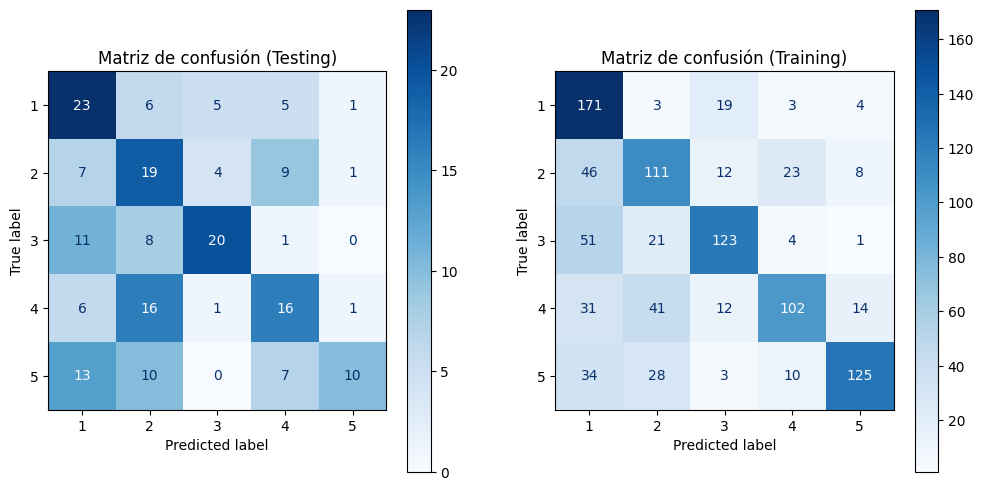

In [161]:
Xtrain_final, _, A, Xm, _ = pca(Xtrain_sfs, n_components=10)
Xtest_final = np.matmul(Xtest_sfs - Xm, A)
get_evaluation(Xtrain_final, Ytrain, Xtest_final, Ytest, k=3)